<a href="https://colab.research.google.com/github/Ar1n382/gmt-projects-/blob/main/Set_Ground_Track_Generator_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This generator is going to be a loop for every second of time this is gonna calculate where the settalite is and at the same time gonna rotate the eart under it then mark it on the spot on a map

In [34]:
#Import necessary libraries

import numpy as np ## numerical calculations
import matplotlib.pyplot as plt # plotting
!pip install cartopy # Install cartopy if not already installed
import cartopy as ccrs # mapping
import astropy # astonomy related conversions
import math
import cartopy.feature as cfeature

In [35]:
#Define the constants for the wgs 84
GM = 3986004.418e8
a = 6378137 #meters
e = 0.00669437999014 #eccentcity squared
Rr = 7.292115e-5 #rad/s rotation rate

#settalite constants from the ISS
h = 400000 #meters altitude
A = a + h  #semi major axis for the orbit of the sat in meters
i = 51.6 #inclanation
eo = 0.0001 # eccentricy nearly a perfect circle
Raan = 0 #right assenction of the ascending node
w  = 0  #arg of periigie

#time array for the low earth orbit (LEO)
time_steps = np.arange(0, 5401, 30) #start: 0 end:5401( a typiccal leo sat take around 90 mins to circle the earth) step = 30s

#The math part
#create a function or a loop that trasfer from the orbital plane to the ECI from ECI to ECEF and ECEF to LAT/LONG

1. The 2D Position (Orbital Plane)

Imagine the satellite is moving on a flat piece of paper. The center of the Earth is at one focus of the ellipse. We use the coordinates xω​ and yω​ to describe where the satellite is on that paper.

First, you need the True Anomaly (v), which is the actual angle of the satellite in its orbit.

    Find Mean Anomaly: M=n×(t−T0​)

    Solve Kepler’s Equation for Eccentric Anomaly (E): M=E−esin(E)

    Calculate True Anomaly (v):
    tan(2v​)=1−e1+e​​tan(2E​)

Create the loop

In your loop, for every time step t, you should do the following:

    Calculate Mean Motion (n): This is the angular speed of the satellite.
    n=A3GM​​

    Calculate Mean Anomaly (M): This is the position if the orbit were a perfect circle.
    M=n×t

    Solve for E: Use a while loop or a for loop to iterate.

In [36]:
lats = []
lons = []

def rotation(vecs,ang,ax):
  #vecs: 3x1 array
  #ang: rotation angle in degrees
  #ax : rotation axis

  #convert degrees to radians
  rad = np.radians(ang)
  c = np.cos(rad)
  s = np.sin(rad)

  #3x3 identity matrix
  R = np.eye(3)

  if ax == 1: #x axis rotation
    R[0,0] = 1
    R[1,1] = c
    R[1,2] = s
    R[2,1] = -s
    R[2,2] = c

  elif ax == 2: #y axis rotation
    R[0,0] = c
    R[0,2] = -s
    R[1,1] = 1
    R[2,0] = s
    R[2,2] = c

  elif ax == 3: #z axis rotation
    R[0,0] = c
    R[0,1] = s
    R[1,0] = -s
    R[1,1] = c
    R[2,2] = 1

  #Matrix mulp
  svec =  R @ vecs
  return svec


def xyz2blh(x, y, z, ell):
    """
    Converts Cartesian coordinates (x, y, z) to Ellipsoidal coordinates (phi, lambda, h).

    Inputs:
        x, y, z: Cartesian coordinates in meters [cite: 19]
        ell: Selected ellipsoid (1: GRS80, 2: WGS84, 3: PZ-90.02) [cite: 20]

    Outputs:
        b: Latitude (phi) in degrees
        l: Longitude (lambda) in degrees
        h: Ellipsoidal height in meters
    """

    # 1. Define Ellipsoid Parameters [cite: 27]
    if ell == 1: # GRS 80
        a = 6378137.0
        inv_f = 298.257222101
    elif ell == 2: # WGS 84
        a = 6378137.0
        inv_f = 298.257223563
    elif ell == 3: # PZ-90.02
        a = 6378136.0
        inv_f = 298.257839303
    else:
        raise ValueError("Invalid ellipsoid selection. Choose 1, 2, or 3.")

    # 2. Calculate derived constants
    f = 1 / inv_f
    e2 = 2 * f - f**2  # Square of eccentricity

    # Pre-calculate sqrt(X^2 + Y^2) as it is used frequently
    s = math.sqrt(x**2 + y**2)

    # 3. Calculate Longitude (lambda)
    # Uses atan2 to handle quadrants correctly
    l_rad = math.atan2(y, x)

    # 4. Initial Approximation for Latitude (phi_0) [cite: 11]
    # Note: math functions use radians
    phi_current = math.atan((z / s) / (1 - e2))

    # 5. Iteration Loop [cite: 8, 9]
    # Precision threshold: 10^-8 degrees converted to radians for comparison
    precision_deg = 10**-8
    precision_rad = math.radians(precision_deg)

    while True:
        # Store the phi from the previous step to check convergence later
        phi_prev = phi_current

        # Calculate Radius of Curvature in the prime vertical (N_bar) [cite: 13]
        sin_phi = math.sin(phi_prev)
        N_bar = a / math.sqrt(1 - e2 * sin_phi**2)

        # Calculate Height (h) [cite: 14]
        h = (s / math.cos(phi_prev)) - N_bar

        # Calculate New Latitude (phi_k) [cite: 15]
        # Note: Assuming N_k in the denominator is the same as N_bar
        numerator = z / s
        denominator = 1 - e2 * (N_bar / (N_bar + h))
        phi_current = math.atan(numerator / denominator)

        # Check Convergence
        if abs(phi_current - phi_prev) < precision_rad:
            break

    # 6. Convert outputs to degrees
    b = math.degrees(phi_current)
    l = math.degrees(l_rad)

    return b, l, h


for t in time_steps:
  #find the mean motion
  n = np.sqrt(GM/A**3)
  #calculate the mean anomaly
  M = n*t
  #find the eccantict anomaly with the keplers formula and itteraiton
  E = M
  threshold = 1e-10
  max_iter = 100

  for i in range(max_iter):
    E_new = M + eo*np.sin(E)
    if abs(E_new - E) < threshold:
        break
    E = E_new
    # find the true annomaly
  v = 2 * np.arctan(np.sqrt((1 + eo) / (1 - eo)) * np.tan(E / 2))

  #find the distance from the earth center r
  r = A * (1 - eo**2) / (1 + eo * np.cos(v))
  xw = r * np.cos(v)
  yw = r * np.sin(v)
  p_orbital= [xw, yw, 0]
  #1.time to tilt the 2d space  into the 3d space using the oriantation angles so finding the ECI
  new_orbit = rotation(p_orbital, -w, 3)
  new_orbit1 = rotation(new_orbit, -i, 1)
  P_ECI = rotation(new_orbit1, -Raan, 3)

  # 2. Calculate how much Earth has rotated at time 't'
  # theta = OMEGA_EARTH * t
  theta = Rr * t
  # 3. Rotate ECI to ECEF using your rotation function
  P_ECEF = rotation(P_ECI, -np.degrees(theta), 3)

  # 4. Convert ECEF to Lat/Lon using your xyz2blh
  lat, lon, h = xyz2blh(P_ECEF[0], P_ECEF[1], P_ECEF[2], 2)

  # 5. Save the results
  lats.append(lat)
  lons.append(lon)

lets check if the lats and long are being filled correctly so we will set up a basic plot


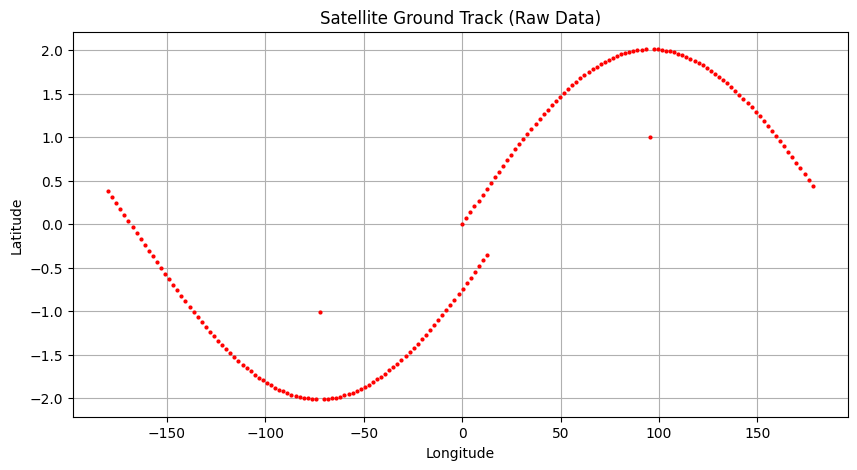

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(lons, lats, 'ro', markersize=2)
plt.title("Satellite Ground Track (Raw Data)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

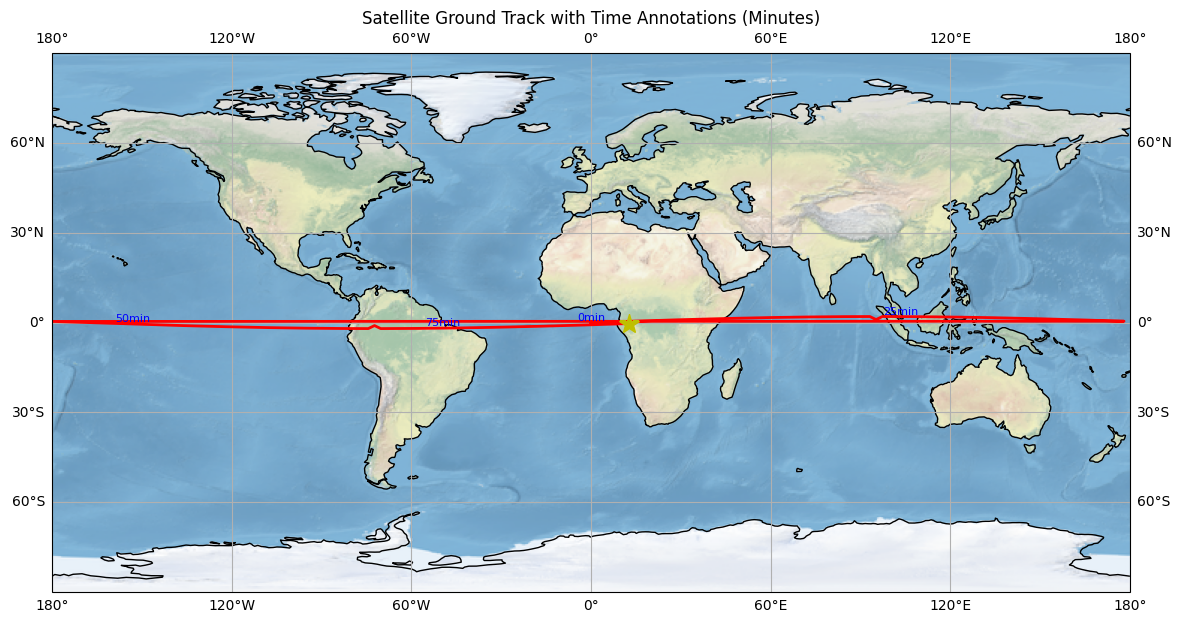

In [41]:
# 1. Setup the figure
fig = plt.figure(figsize=(15, 7))
ax = plt.axes(projection=ccrs.crs.PlateCarree())

# 2. Add map details
ax.stock_img()          # Adds a nice satellite-style background
ax.coastlines()         # Draws the continents
ax.gridlines(draw_labels=True) # Adds lat/lon grid lines

# 3. Plot your ground track
# We use 'transform=ccrs.PlateCarree()' to tell Cartopy these are lat/lon
ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.crs.PlateCarree())

# 4. (Optional) Mark the current position with a star
ax.plot(lons[-1], lats[-1], 'y*', markersize=15, transform=ccrs.crs.PlateCarree())

# 5. Add time annotations at intervals
# Choose an interval to avoid cluttering the map (e.g., every 50th point)
annotation_interval = 50
for i in range(0, len(lats), annotation_interval):
    ax.text(lons[i], lats[i], f'{int(time_steps[i] / 60)}min',
            transform=ccrs.crs.PlateCarree(),
            color='blue', fontsize=8, ha='center', va='bottom')

plt.title('Satellite Ground Track with Time Annotations (Minutes)')
plt.show()